In [1]:
import rescomp as rc
import numpy as np
from scipy.interpolate import CubicSpline
from scipy import integrate, sparse
from scipy.stats import pearsonr
from scipy.sparse.linalg import eigs, ArpackNoConvergence
from scipy.sparse import coo_matrix
import math 
import networkx as nx
import itertools
import csv
import time
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [20, 5]
# Set seed for reproducibility
np.random.seed(1)
from math import comb
import h5py
from mpi4py import MPI
import traceback
import logging
import importlib

--------------------------------------------------------------------------

  Local host:   login02
  Local device: mlx5_0
--------------------------------------------------------------------------


### Helper functions

In [3]:
def nrmse(true, pred):
        """ Normalized root mean square error. (A metric for measuring difference in orbits)
        Parameters:
            Two mxn arrays. Axis zero is assumed to be the time axis (i.e. there are m time steps)
        Returns:
            err (ndarray): Error at each time value. 1D array with m entries
        """
        # sig = np.std(true, axis=0)
        # err = np.linalg.norm((true-pred) / sig, axis=1, ord=2)
        err = np.linalg.norm((true-pred), axis=1, ord=2) # Just regular 2-norm
        return err

def valid_prediction_index(err, tol):
    """First index i where err[i] > tol. err is assumed to be 1D and tol is a float. If err is never greater than tol, then len(err) is returned."""
    mask = np.logical_or(err > tol, ~np.isfinite(err))
    if np.any(mask):
        return np.argmax(mask)
    return len(err)

def vpt_time(ts, Uts, pre, vpt_tol=5.):
    """
    Valid prediction time for a specific instance.
    """
    err = nrmse(Uts, pre)
    idx = valid_prediction_index(err, vpt_tol)
    if idx == 0:
        vptime = 0.
    else:
        vptime = ts[idx-1] - ts[0]
    return vptime

def div_metric_tests(states):
    """ Compute Diversity scores of predictions
    """
    # Take the derivative of the pred_states
    res_deriv = np.gradient(states, axis=0)
    T, n = states.shape

    # Run the metric for the old and new diversity scores
    div_pos = 0
    div_der = 0
    for i in range(n):
        for j in range(i+1, n):
            div_pos += np.sum(np.abs(np.abs(np.abs(states[:T, i]) - np.abs(states[:T, j]))))
            print(div_pos)
            div_der += np.sum(np.abs(np.abs(res_deriv[:T, i]) - np.abs(res_deriv[:T, j])))
    denom = T*comb(n,2)
    div_pos = div_pos / denom
    div_der = div_der / denom

    return div_pos, div_der

def remove_edges(A,n_edges):
    """ Randomly removes 'n_edges' edges from a sparse matrix 'A'
    """
    B = A.copy().todok() # - - - - - - - -  set A as copy

    keys = list(B.keys()) # - - - - remove edges
   
    remove_idx = np.random.choice(range(len(keys)),size=n_edges, replace=False)
    remove = [keys[i] for i in remove_idx]
    for e in remove:
        B[e] = 0
    return B

def random_graph(n, p):
    """ Create the sparse adj matrix of a random directed graph
        on n nodes with probability of any link equal to p
    """
    A = sparse.random(n,n, density=p, dtype=float, format="lil")
    # Remove self edges
    for i in range(n):
        A[i,i] = 0.0
    # Add one loop to ensure positive spectral radius
    if n > 1:
        A[0, 1] = 1.
        A[1, 0] = 1.
    return A

def scale_spect_rad(A, rho):
    """ Scales the spectral radius of the reservoir so that
        _spectral_rad(self.res) = self.spect_rad
    """

    def _spectral_rad(A):
        """ Compute spectral radius via max radius of the strongly connected components """
        g = nx.DiGraph(A.T)
        # if self.sparse_res:
        #     A = A.copy().todok()
        scc = nx.strongly_connected_components(g)
        rad = 0
        for cmp in scc:
            # If the component is one node, spectral radius is the edge weight of it's self loop
            if len(cmp) == 1:
                i = cmp.pop()
                max_eig = A[i,i]
            else:
                # Compute spectral radius of strongly connected components
                adj = nx.adjacency_matrix(nx.subgraph(g,cmp))
                max_eig = np.max(np.abs(np.linalg.eigvals(adj.T.toarray())))
            if max_eig > rad:
                rad = max_eig
        return rad

    curr_rad = _spectral_rad(A)
    if not np.isclose(curr_rad,0, 1e-8):
        A *= rho/curr_rad
    else:
        print("Spectral radius of reservoir is close to zero. Edge weights will not be scaled")
    # end
    # Convert to csr if sparse
    if sparse.issparse(A):
        A = A.tocsr()
    return A

def pearson_consistency_metric(states, states_perturbed):
    """ Compute the consistency metric for predicted states based on the Echo State Paper - Pearson Correlation Coefficient 
        Parameters:
        ----------
        states: ndarray(T,n)
            States using unperturbed initial state r0. T = time, n = number of nodes

        states_perturbed: ndarray(T,n)
            Perturbed states using perturbed initial state r0. T = time, n = number of nodes

        Returns:
        --------
        aggregated_pearson_correlation_coeff: float 
            The aggregated pearson correlation coefficient between the two response states
    """
    if len(states.shape) == 1:
        return pearsonr(states, states_perturbed)[0]
    else:
        T, n = states.shape
        gammas = np.zeros(n)
        for i in range(n):
            gammas[i] = pearsonr(states[:,i], states_perturbed[:,i])[0]
        # pearsonr is not defined for constant state vectors so nan will be returned - remove these from the array
        aggregated_pearson_correlation_coeff = np.mean(gammas[np.isfinite(gammas)])
        return aggregated_pearson_correlation_coeff

### Consistency Analysis

In [3]:
import numpy as np

def consistency_analysis(x, y, alpha=1e-9):
    """ Based on the Appendix: Consistency Analysis walkthrough sent by Dr. Lymburn
        Parameters:
        ----------
        x: ndarray(L,N)
            States using initial state r0. L = time, n = number of nodes

        y: ndarray(L,N)
            States using different initial state r0 prime. L = time, n = number of nodes

        Returns:
        --------
        cap: float
            The consistency capacity of the system
        S: ndarray(N)
            Each node's consistency
    """
    L, N = np.shape(x)

    # Center x and y around 0
    x = x - np.mean(x)
    y = y - np.mean(y)

    # Calculate Covariance Matrices
    Cxx = x.T @ x / L
    Cyy = y.T @ y / L

    # Save space by averaging the two
    C = (Cxx + Cyy) / 2.

    # Add regularization term 
    C = C + alpha * np.eye(N)

    # Compute SVD
    U, S, Vh = np.linalg.svd(C)
    Qxx = U
    S_inv = np.diag(1. / np.sqrt(S))

    # Apply spherical transformation T_o
    T_o = Qxx @ S_inv @ Qxx.T
    x = T_o @ x.T
    y = T_o @ y.T

    # Calculate Cross-variance matrix
    Cxy = x.T @ y / L
    Css = (Cxy + Cxy.T) / 2.

    # Calculate SVD of Css to find principal components of consistency
    U, S, Vh = np.linalg.svd(Css)

    # Calculate consistency capacity
    cap = np.sum(S) / N

    return cap, S

### Thinned Matrix Analysis

In [6]:
t, U = rc.orbit('lorenz', duration=50)
u = CubicSpline(t, U)
t_train = t[:4000]
U_train = u(t[:4000])
t_test = t[4000:]
U_test = u(t[4000:])
eps = 1e-5
tol = 5.

n, erdos_c, gamma, sigma, alpha = 50, 4, 16.470072504771654, 0.24581307008326905, 0.00827891588205206

In [8]:
rho = 50.0
p_thin = 0.9

# Generate thinned networks
A_thinned = nx.erdos_renyi_graph(n,erdos_c*(1-p_thin)/(n-1),directed=True)
A_thinned = sparse.dok_matrix(nx.adjacency_matrix(A_thinned).T)
A_thinned_rho = np.max(np.abs(sparse.linalg.eigs(A_thinned.astype(float))[0]))
if A_thinned_rho < 1e-8:
    raise ValueError('Thinned Matrix Spectral Radius too small for scaling')
A_thinned = A_thinned*(rho/np.max(np.abs(sparse.linalg.eigs(A_thinned.astype(float))[0])))

# Run the thinned network
res_thinned = rc.ResComp(A_thinned.tocoo(), res_sz=n, ridge_alpha=alpha, spect_rad=rho, sigma=sigma, gamma=gamma)
res_thinned.train(t_train, U_train)

# t_curr = time_comp(t_curr, f"Train Thinned")

# Calculate Consistency Metric
r0 = res_thinned.initial_condition(U_train[0])
r0_perturbed = r0 + np.random.multivariate_normal(np.zeros(n), np.eye(n)*eps)
states = res_thinned.internal_state_response(t_train, U_train, r0)
states_perturbed = res_thinned.internal_state_response(t_train, U_train, r0_perturbed)
consistency_correlation = pearson_consistency_metric(states, states_perturbed)

# t_curr = time_comp(t_curr, f"States and Consistency Thinned")

# Forecast and compute the vpt along with diversity metrics
U_pred, pred_states = res_thinned.predict(t_test, r0=res_thinned.r0, return_states=True)
error = np.linalg.norm(U_test - U_pred, axis=1)
vpt = vpt_time(t_test, U_test, U_pred, vpt_tol=tol)
divs = div_metric_tests(pred_states, T=len(t_test), n=n)

print(divs)

(0.13992741202588144, 0.014438396484604859)


/home/seyfdall/.conda/envs/reservoir/lib/python3.12/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


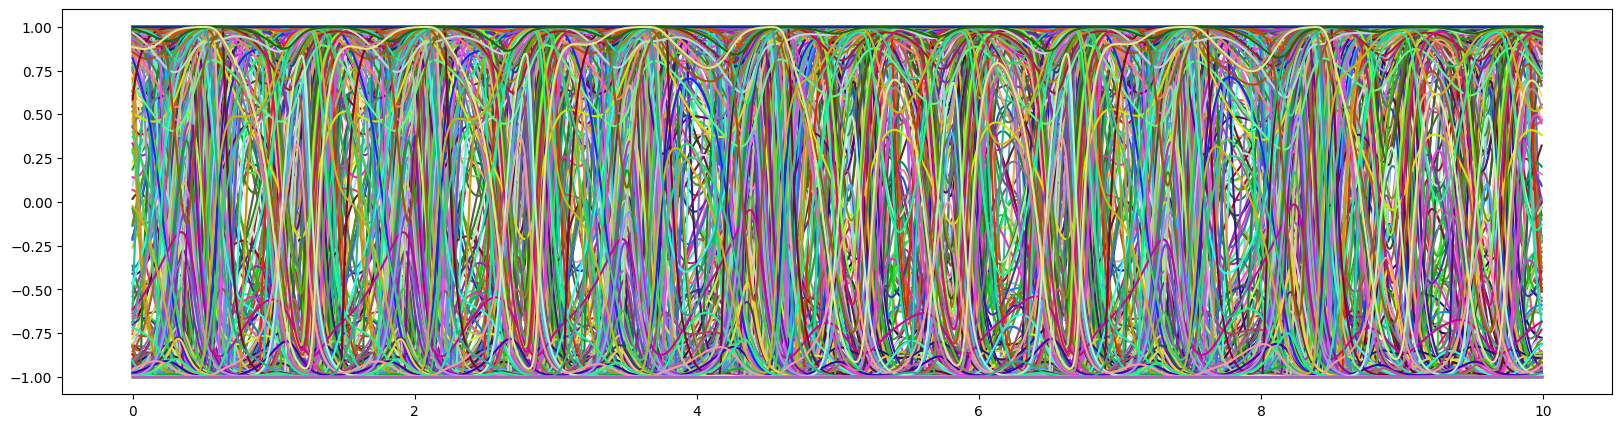

In [6]:
rc.plot2d(t[:1000], pred_states[:1000])
plt.show()

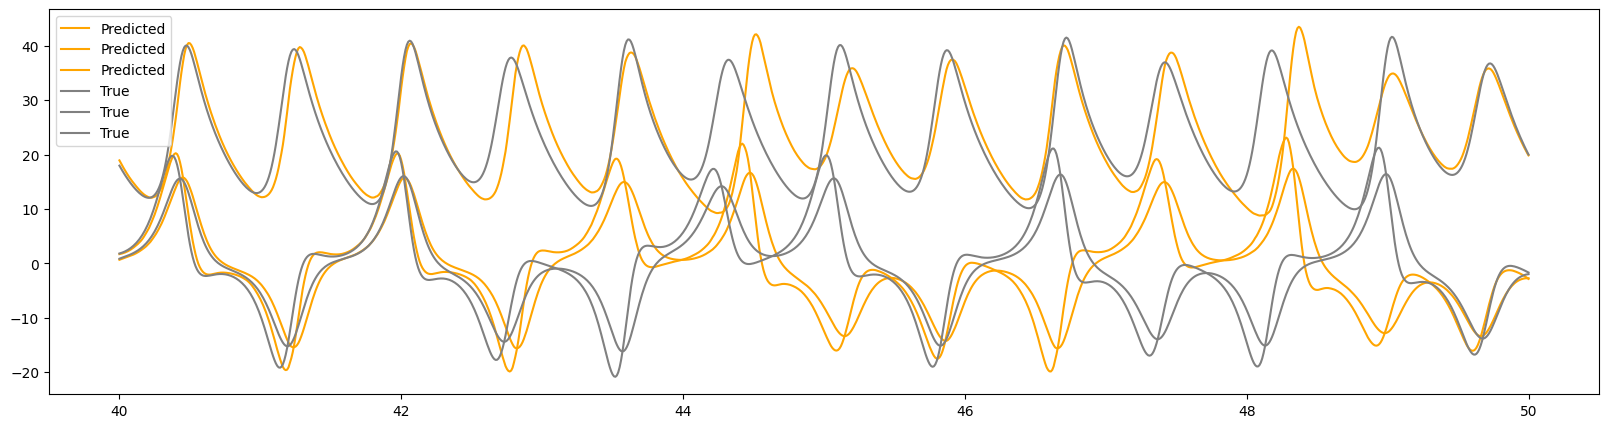

In [7]:
test_t = t[4000:]
plt.plot(test_t, U_pred, c="orange", label="Predicted")
plt.plot(test_t, u(test_t), c="gray", label="True")
plt.legend()
plt.show()

### Test with smaller bounds

In [6]:
t, U = rc.orbit('lorenz', duration=50)
u = CubicSpline(t, U)
t_train = t[:4000]
U_train = u(t_train)
t_test = t[4000:]
U_test = u(t_test)
eps = 1e-5
tol = 5.

n, erdos_c, gamma, sigma, alpha = 50, 4, 16.470072504771654, 0.24581307008326905, 0.00827891588205206
rho = 50.0
p_thin = 0.98

In [8]:
res_thinned = rc.ResComp(res_sz=n, mean_degree=erdos_c*(1-p_thin), 
                            ridge_alpha=alpha, spect_rad=rho, sigma=sigma, 
                            gamma=gamma, map_initial='activ_f')                
res_thinned.train(t_train, U_train)

# t_curr = time_comp(t_curr, f"Train Thinned")

# Calculate Consistency Metric
r0 = res_thinned.initial_condition(U_train[0])
r0_perturbed = r0 + np.random.multivariate_normal(np.zeros(n), np.eye(n)*eps)
states = res_thinned.internal_state_response(t_train, U_train, r0)
states_perturbed = res_thinned.internal_state_response(t_train, U_train, r0_perturbed)
consistency_correlation = pearson_consistency_metric(states, states_perturbed)

# t_curr = time_comp(t_curr, f"States and Consistency Thinned")

# Forecast and compute the vpt along with diversity metrics
U_pred, pred_states = res_thinned.predict(t_test, r0=res_thinned.r0, return_states=True)
error = np.linalg.norm(U_test - U_pred, axis=1)
vpt = vpt_time(t_test, U_test, U_pred, vpt_tol=tol)
divs = div_metric_tests(pred_states)

In [9]:
print(U_pred.shape, U_test.shape)

(1001, 3) (1001, 3)


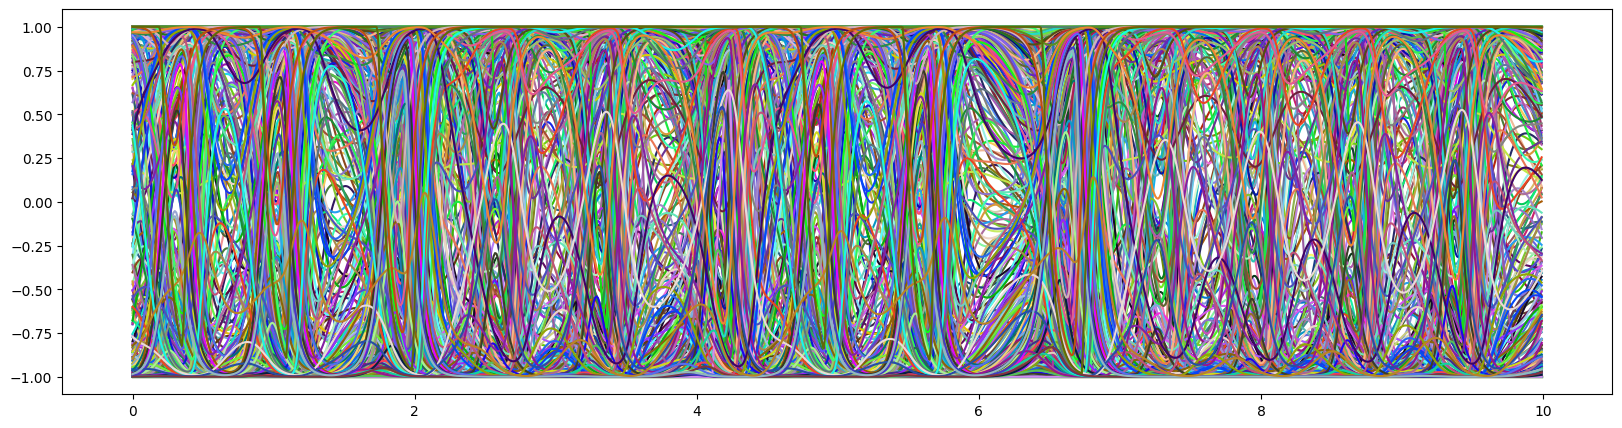

In [10]:
rc.plot2d(t[:1000], pred_states[:1000])
plt.show()

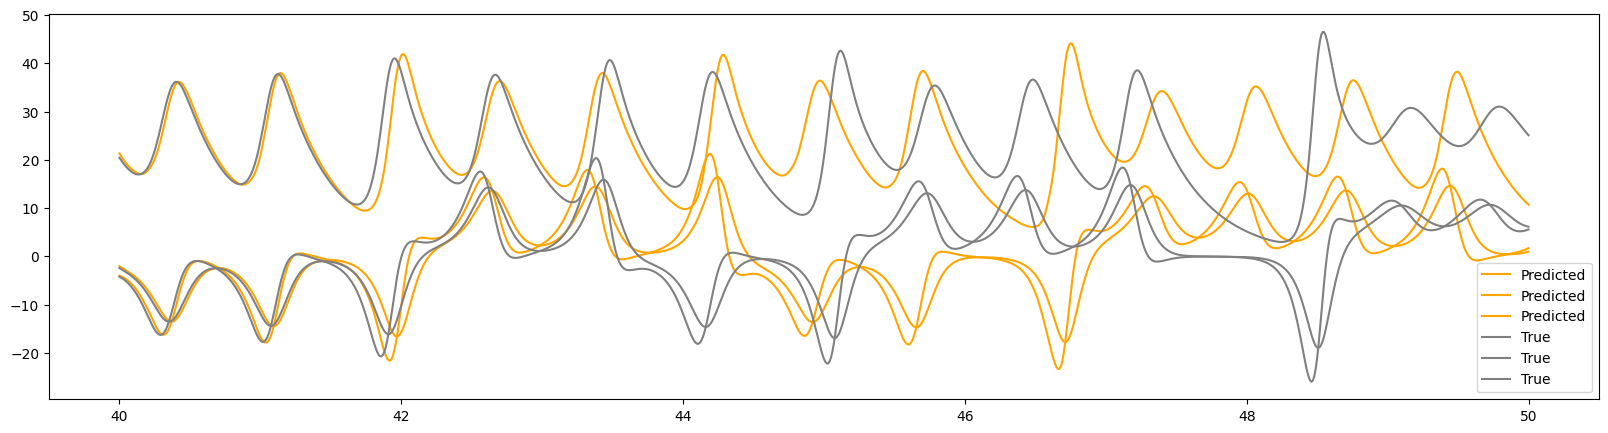

In [11]:
test_t = t[4000:]
plt.plot(test_t, U_pred, c="orange", label="Predicted")
plt.plot(test_t, u(test_t), c="gray", label="True")
plt.legend()
plt.show()

### Consistency Scratch Work

In [41]:
t, U = rc.orbit('lorenz', duration=50)
u = CubicSpline(t, U)
t_train = t[:4000]
U_train = u(t[:4000])
t_test = t[4000:]
U_test = u(t[4000:])
eps = 1e-5
tol = 5.
rho = 2.2

n, erdos_c, gamma, sigma, alpha = 50, 4, 16.470072504771654, 0.24581307008326905, 0.00827891588205206
p = erdos_c / n
A_1 = random_graph(n, p)
A_1 = scale_spect_rad(A_1, rho)
A_2 = A_1.copy()

In [42]:
# First replica run
r0_1 = np.random.uniform(-1., 1., n)
res_1 = rc.ResComp(A_1, res_sz=n, ridge_alpha=alpha, spect_rad=rho, sigma=sigma, gamma=gamma)
states_1 = res_1.internal_state_response(t_train, U_train, r0_1)

# Second replica run
r0_2 = np.random.uniform(-1., 1., n)
res_2 = rc.ResComp(A_2, res_sz=n, ridge_alpha=alpha, spect_rad=rho, sigma=sigma, gamma=gamma)
states_2 = res_1.internal_state_response(t_train, U_train, r0_2)

In [49]:
# Compute Consistency
cap, S = consistency_analysis(states_1, states_2)
pearson_cap = pearson_consistency_metric(states_1, states_2)
print(cap, S[0], pearson_cap)

0.8602382387931606 0.9999999966549318 0.989350360675421


In [44]:
print(S)
print(states_1.shape)
print(len(states_1[:,0]))

[9.99999997e-01 9.99999986e-01 9.99999970e-01 ... 2.09307632e-17
 1.26468225e-17 4.13904791e-18]
(4000, 50)
4000


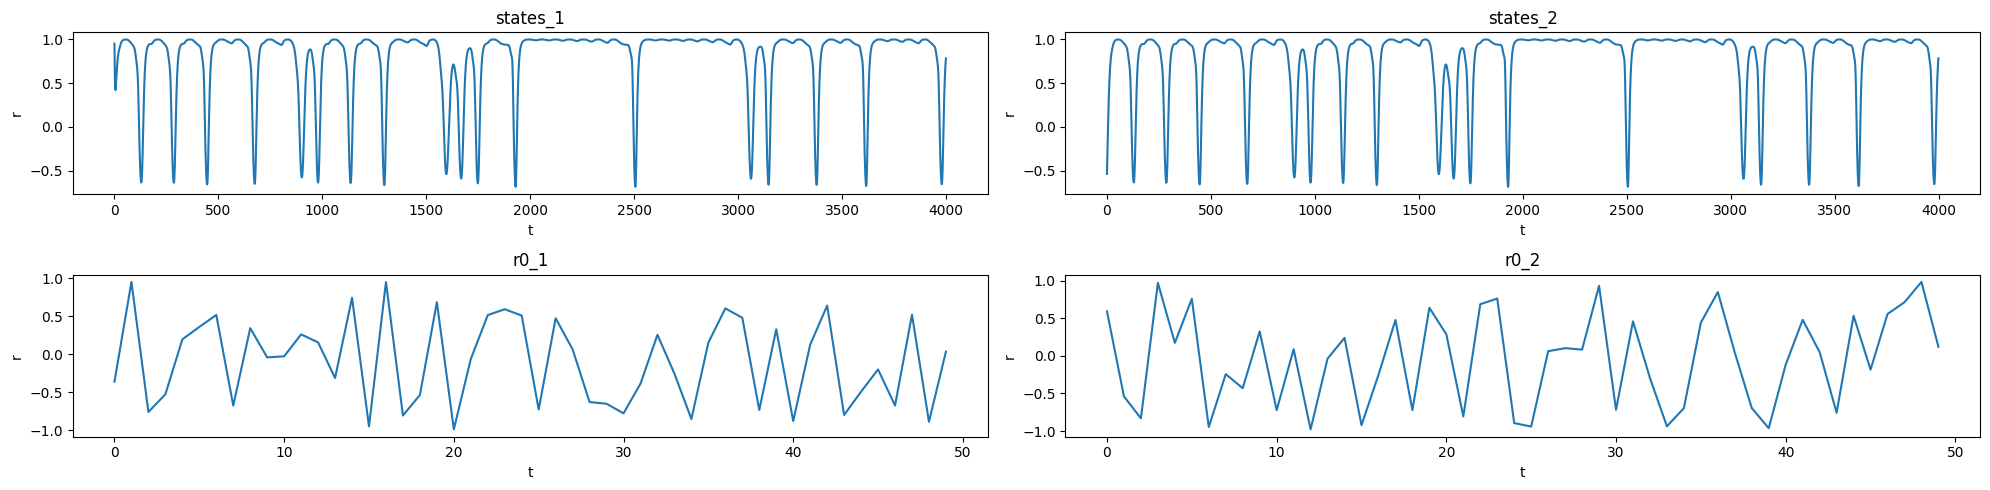

In [45]:
plt.subplot(221)
plt.title("states_1")
plt.plot(states_1[:,1])
plt.ylabel("r")
plt.xlabel("t")

plt.subplot(222)
plt.title("states_2")
plt.plot(states_2[:,1])
plt.ylabel("r")
plt.xlabel("t")

plt.subplot(223)
plt.title("r0_1")
plt.plot(r0_1)
plt.ylabel("r")
plt.xlabel("t")

plt.subplot(224)
plt.title("r0_2")
plt.plot(r0_2)
plt.ylabel("r")
plt.xlabel("t")

plt.tight_layout()
plt.show()

### Inhouse Rescomp


In [4]:
import sys
import os
sys.path.insert(0, os.path.abspath('/nobackup/autodelete/usr/seyfdall/network_theory/rescomp_package/rescomp'))
import ResComp
import chaosode

In [ ]:
t, U = chaosode.orbit('lorenz', duration=50)
u = CubicSpline(t, U)
t_train = t[:4000]
U_train = u(t[:4000])
t_test = t[4000:]
U_test = u(t[4000:])
eps = 1e-5
tol = 5.

n, erdos_c, gamma, sigma, alpha = 5, 4, 16.470072504771654, 0.24581307008326905, 0.00827891588205206
rho = 50.0
p_thin = 0.98

In [ ]:
importlib.reload(ResComp)
res_thinned = ResComp.ResComp(res_sz=n, mean_degree=erdos_c*(1-p_thin), 
                            ridge_alpha=alpha, spect_rad=rho, sigma=sigma, 
                            gamma=gamma, map_initial='activ_f')   
res_thinned.train(t_train, U_train)
print(res_thinned.states.shape)
print(div_metric_tests(res_thinned.states))

(4000, 5)
(0.2806968341647946, 0.008598401884276349)


### Manual Diversity Testing

In [27]:
def div_metric_tests(states):
    """ Compute Diversity scores of predictions
    """
    # Take the derivative of the pred_states
    res_deriv = np.gradient(states, axis=0)
    T, n = states.shape
    print(res_deriv)

    # Run the metric for the old and new diversity scores
    div_pos = 0
    div_der = 0
    for i in range(n):
        for j in range(i+1, n):
            div_pos += np.sum(np.abs(np.abs(np.abs(states[:T, i]) - np.abs(states[:T, j]))))
            div_der += np.sum(np.abs(np.abs(res_deriv[:T, i]) - np.abs(res_deriv[:T, j])))
    denom = T*comb(n,2)
    div_pos = div_pos / denom
    div_der = div_der / denom

    return div_pos, div_der

# All ones test - expecting zero diversity in both metrics
states = np.ones((10,10))
# print(states)
# print(div_metric_tests(states), "\n")

# Alternating +/- ones test - expecting zero diversity in both metrics
states = np.ones((2,2))
states[:,1::2] = -1
# print(states)
# print(div_metric_tests(states), "\n")

# Slowly increasing nodes with same slopes at different values - expecting nonzero pos and zero der
states = np.array([[0.5, 0.6, 0.7, 0.8, 0.9], [0.0, 0.1, 0.2, 0.3, 0.4]]).T
# print(states)
# print(div_metric_tests(states), "\n")

# Crazy slopes of different derivatives that sum to the same position wise
states = np.array([[0.5,1.0,0.5,0.0,0.5], [-0.5,-1.0,-0.5,-0.0,-0.5]]).T
print(states)
print(div_metric_tests(states), "\n")

[[ 0.5 -0.5]
 [ 1.  -1. ]
 [ 0.5 -0.5]
 [ 0.  -0. ]
 [ 0.5 -0.5]]
[[ 0.5 -0.5]
 [ 0.   0. ]
 [-0.5  0.5]
 [ 0.   0. ]
 [ 0.5 -0.5]]
(0.0, 0.0) 



### Manual VPT Testing


In [9]:
t, U = chaosode.orbit('lorenz', duration=50)
u = CubicSpline(t, U)
t_train = t[:4000]
U_train = u(t[:4000])
t_test = t[4000:]
U_test = u(t[4000:])
eps = 1e-5
tol = 5.

n, erdos_c, gamma, sigma, alpha = 50, 4, 16.470072504771654, 0.24581307008326905, 0.00827891588205206
rho = 2.2
p_thin = 0.05

mean_degree = erdos_c*(1-p_thin)
if mean_degree < 0.0:
    mean_degree = 0.0

res_thinned = ResComp.ResComp(res_sz=n, mean_degree=mean_degree, 
                                         ridge_alpha=alpha, spect_rad=rho, sigma=sigma, 
                                         gamma=gamma, map_initial='activ_f')       

# Train the matrix         
res_thinned.train(t_train, U_train)

# Forecast and compute the vpt along with diversity metrics
U_pred = res_thinned.predict(t_test, r0=res_thinned.r0, return_states=True)[0]

In [10]:
def nrmse(true, pred):
        """ Normalized root mean square error. (A metric for measuring difference in orbits)
        Parameters:
            Two mxn arrays. Axis zero is assumed to be the time axis (i.e. there are m time steps)
        Returns:
            err (ndarray): Error at each time value. 1D array with m entries
        """
        # sig = np.std(true, axis=0)
        # err = np.linalg.norm((true-pred) / sig, axis=1, ord=2)
        err = np.linalg.norm((true-pred), axis=1, ord=2) # Just regular 2-norm
        return err

def valid_prediction_index(err, tol):
    """First index i where err[i] > tol. err is assumed to be 1D and tol is a float. If err is never greater than tol, then len(err) is returned."""
    mask = np.logical_or(err > tol, ~np.isfinite(err))
    if np.any(mask):
        return np.argmax(mask)
    return len(err)

def vpt_time(ts, Uts, pre, vpt_tol=5.):
    """
    Valid prediction time for a specific instance.
    """
    err = nrmse(Uts, pre)
    idx = valid_prediction_index(err, vpt_tol)
    if idx == 0:
        vptime = 0.
    else:
        vptime = ts[idx-1] - ts[0]
    return vptime

error = np.linalg.norm(U_test - U_pred, axis=1)
vpt = vpt_time(t_test, U_test, U_pred, vpt_tol=tol)
print(error.shape)
print(U_pred.shape)
print(vpt)

(1001,)
(1001, 3)
0.7800000000000011


### Force the same system

In [5]:
t, U = chaosode.orbit('lorenz', duration=100)
u = CubicSpline(t, U)
t_train = t[:9000]
U_train = u(t_train)
t_test = t[9000:]
U_test = u(t_test)
eps = 1e-5
tol = 5.

n, erdos_c, gamma, sigma, alpha = 50, 4, 5, 0.14, 1e-6
rho = 2.
p_thin = 0.96

In [7]:
t = np.load("orbit_t.npy")
U = np.load("orbit_U.npy")
A = np.load("A.npy")
r0 = np.load("r0.npy")
W_in = np.load("W_in.npy")

In [17]:
importlib.reload(ResComp)

u = CubicSpline(t, U)
t_train = t[:9000]
U_train = u(t_train)
t_test = t[9000:]
U_test = u(t_test)
eps = 1e-5
tol = 5.

n, erdos_c, gamma, sigma, alpha = 50, 4, 5, 0.14, 1e-6
rho = 2.
p_thin = 0.4

mean_degree = erdos_c*(1-p_thin)
if mean_degree < 0.0:
    mean_degree = 0.0

res_thinned = ResComp.ResComp(A, res_sz=n, mean_degree=mean_degree, batchsize=9000,
                                         ridge_alpha=alpha, spect_rad=rho, sigma=sigma, 
                                         gamma=gamma, map_initial='activ_f')       

# Train the matrix         
res_thinned.train(t_train, U_train)

# Forecast and compute the vpt along with diversity metrics
U_pred = res_thinned.predict(t_test, r0=res_thinned.r0, return_states=True)[0]

print(np.linalg.eigvals(res_thinned.res))
print(res_thinned.res)
print(vpt_time(t_test, U_test, U_pred, vpt_tol=5.))

/nobackup/autodelete/usr/seyfdall/network_theory/rescomp_package/rescomp/ResComp.py:189: UserWarning: Spectral radius of reservoir is close to zero. Edge weights will not be scaled
  warn("Spectral radius of reservoir is close to zero. Edge weights will not be scaled")


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
3.3500000000000085


### Testing main

In [9]:
import main
import file_io
import importlib

importlib.reload(file_io)
importlib.reload(main)

main.main()

param_set_0_n=50_erdos_c=4_gamma=0.5_sigma=0.5_alpha=1.0 <KeysViewHDF5 []> False 

param_set_1_n=50_erdos_c=4_gamma=0.5_sigma=0.5_alpha=1.0 <KeysViewHDF5 ['param_set_0_n=50_erdos_c=4_gamma=0.5_sigma=0.5_alpha=1.0']> False 



### Test File_io


In [ ]:
# import traceback
# import importlib
# import utils.file_io as file_io
# importlib.reload(file_io)

# try:
#     rho, p_thin = 2.1, 0.1
#     n, erdos_c, gamma, sigma, alpha = 50, 4, 0.5, 0.5, 1.0

#     # Initialize the file handler
#     file_handler = file_io.HDF5FileHandler('results/', rho=rho, p_thin=p_thin)
    
#     # Ensure file is opened in a context-managed block
#     with file_handler:  # Assumes your HDF5FileHandler supports the context manager protocol
#         group_handler = file_handler.get_group_handler(
#             f"param_set_0", n=n, erdos_c=erdos_c, gamma=gamma, sigma=sigma, alpha=alpha
#         )
        
#         # Load file-level attributes
#         file_handler.save_attrs()
#         print(file_handler.attrs)
#         file_handler.load_attrs()
#         print(file_handler.attrs)
#         for key, value in file_handler.attrs.items():
#             print(f"{key}: {value}")

#         # Load group-level data
#         group_handler.save_data()
#         group_handler.load_data()
#         print(list(group_handler.group.attrs.values()))
#         print(group_handler.datasets)
#         print(group_handler.attrs)

# except Exception as e:
#     print(f"Error: {e}")
#     traceback.print_exc()

# finally:
#     # Ensure the file is closed in case of an exception
#     if 'file_handler' in locals():
#         try:
#             file_handler.close_file()
#         except Exception as cleanup_error:
#             print(f"Error while closing the file: {cleanup_error}")

1


In [14]:
# import os
# os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
import traceback
import importlib
import utils.file_io as file_io
importlib.reload(file_io)

file_handler = file_io.HDF5FileHandler('results/erdos_results', rho=2.0, p_thin=0.1)
try:
    file_handler.open_file('r')
    file_handler.load_attrs()
    print(file_handler.attrs)

    print(file_handler.file.keys())
    print(file_handler.file.attrs.keys())
    group_handler = file_handler.get_group_handler(
        f"param_set_0", n=50, erdos_c=4, gamma=0.5, sigma=0.5, alpha=1.0
    )
    group_handler.load_data()
    print(group_handler.attrs)
    print(group_handler.datasets)
except Exception as e:
    traceback.print_exc()
    print(e)
finally:
    file_handler.close_file()

{'p_thin': 0.1, 'rho': 2.0}
<KeysViewHDF5 ['param_set_0_n=50_erdos_c=4_gamma=0.5_sigma=0.5_alpha=1.0', 'param_set_1_n=50_erdos_c=4_gamma=0.5_sigma=0.5_alpha=1.0']>
<KeysViewHDF5 ['p_thin', 'rho']>
{'alpha': 1.0, 'erdos_c': 4, 'gamma': 0.5, 'mean_consistency_correlation': 0.7065875489425174, 'mean_div_der': 0.001624069865511385, 'mean_div_pos': 0.254616151945524, 'mean_err': 30.45985911744954, 'mean_pred': 15.363107022832867, 'mean_vpt': 0.28000000000000114, 'n': 50, 'sigma': 0.5}
{'consistency_correlation': array([0.70658755]), 'div_der': array([0.00162407]), 'div_pos': array([0.25461615]), 'err': array([[ 2.52634276,  2.45160675,  2.37981393, ..., 88.39097616,
        88.72751756, 89.03939508]]), 'pred': array([[[ -0.68271587,   0.48939024,  19.4529361 ],
        [ -0.55503631,   0.58033784,  18.91819032],
        [ -0.43332617,   0.67586217,  18.38791903],
        ...,
        [-36.53250949, -45.13404091,  89.68446935],
        [-36.40544171, -44.63067909,  90.02658573],
        [-36

In [2]:
import utils.helper as helper
rho_p_thin_prod, erdos_possible_combinations = helper.gridsearch_parameter_setup()
print(len(erdos_possible_combinations))

1800
